In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import sys
from multiprocessing import Pool
import matplotlib.pyplot as plt
%matplotlib inline

## Data Preprocessing:

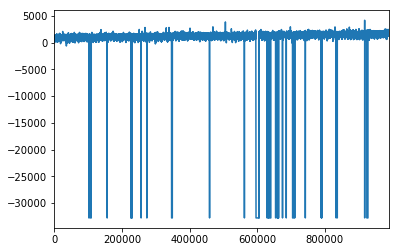

In [2]:
dfSL = pd.read_csv('Galveston.csv', header=None)
dfSL.rename(columns={0:'year',1:'month', 2:'day', 3:'hour', 4: 'sealevel'}, inplace=True)
fill_in = dfSL.loc[dfSL['sealevel']<-5000].median()[4]
dfSL['sealevel'].plot()
plt.show()

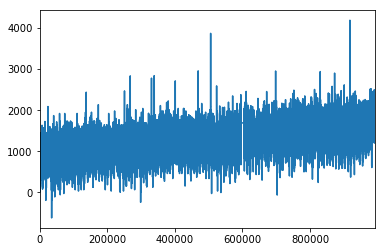

In [3]:
dfSL['sealevel'].replace(fill_in, np.nan, inplace=True)
dfSL.dropna(inplace= True)
dfSL['sealevel'].plot()
plt.show()

In [4]:
n_hours = 365*24
sl_year = {}
for index, row in dfSL.iterrows():
    year = row['year']
    sl = row['sealevel']
    if year in sl_year:
        sl_year[year].append(sl)
    else:
        sl_year[year] = []
        sl_year[year].append(sl)
        
gev= {}
for year, sealevel in sl_year.items():
    if len(sealevel)/n_hours >= 0.9:
        gev[year] = max(np.array(sealevel)-np.mean(sealevel))
        

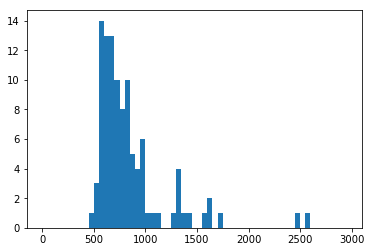

In [5]:
plt.hist(list(gev.values()), bins=np.arange(0, 3000, 50))
plt.show()

In [6]:
data_meas = list(gev.values())
len(data_meas)

103

## Likelihood Function:

In [7]:
def likelihood(parameters, data_meas):
    u, s, shape = parameters                                                 
    prod = 1
    for i in range(len(data_meas)):
        pdf = stats.genextreme.pdf(x=data_meas[i], loc=u, scale=s, c=shape)
        if (pdf==0):
            return -np.inf
        prod += np.log(pdf)
    return prod

## Prior Distribution:

In [8]:
def prior(parameters):
    u, s, shape = parameters
    u_pdf = stats.norm.pdf(x=u, loc=0, scale=100) # postive
    shape_pdf = stats.norm.pdf(x=shape, loc=0, scale=100)
    if s >= 1000 or s <= 0 or u_pdf==0 or shape_pdf==0:
        return -np.inf
    else:
        return np.log(u_pdf)+np.log(1/1000)+np.log(shape_pdf)

## Posterior Distribution:

In [9]:
def logpost(parameters, data_meas):
    pi = prior(parameters)
    if pi == -np.inf:
        return -np.inf
    L = likelihood(parameters, data_meas)
    return L + pi

## Metropolis-Hastings Algorithm


In [10]:
eps = 0.0001
d = 3                                                                                                                                                                                                                                                                                                  
I_d = np.identity(d)
S_d = (2.4)**2/d
def update_cov(X):
    cov = np.cov(X)
    return S_d*cov + I_d*eps*S_d

In [11]:
class State: 
    def __init__(self, state, value):
        self.state = state 
        self.value = value 

class ProblemMCMC: 
    def __init__(self, initial, logposterior, stepsize, data_meas, t):
        self.current = initial 
        self.logpost = logposterior 
        self.stepsize = stepsize 
        self.data_meas = data_meas
        self.t = t
        
    def random_move(self, t, X):
        if (t <= self.t):
            next_move = stats.multivariate_normal.rvs(self.current.state, self.stepsize)
        else:
            cov = update_cov(X)
            next_move = stats.multivariate_normal.rvs(self.current.state, cov)
        return next_move, self.logpost(next_move, self.data_meas)

In [12]:
def mcmc(problem, n_iter):

    u = [problem.current.state[0]] 
    s = [problem.current.state[1]]
    shape = [problem.current.state[2]]
    lpost = [problem.current.value]    
    n_accept = 0
    S = 0
    np.seterr(over='ignore')
    
    with Pool(8) as p:
        for t in range(n_iter):
            S += 1
            nextMove, nextValue = problem.random_move(t, [u, s, shape])
            delta_obj = np.exp(nextValue - lpost[-1])
            if delta_obj > 1:
                # the proposed move is an improvement, so accept w.p. 1
                n_accept += 1
                u.append(nextMove[0])
                s.append(nextMove[1])
                shape.append(nextMove[2])
                lpost.append(nextValue)
                problem.current.state = nextMove
                problem.current.value = nextValue
            else:
                # the proposed move is worse; accept with probability exp[delta_obj/T]
                p_accept = delta_obj
                accept = np.random.choice([True, False], p=[p_accept, 1-p_accept])
                if accept:
                    n_accept += 1
                    u.append(nextMove[0])
                    s.append(nextMove[1])
                    shape.append(nextMove[2])
                    lpost.append(nextValue)
                    problem.current.state = nextMove
                    problem.current.value = nextValue
                else:
                    u.append(u[-1])
                    s.append(s[-1])
                    shape.append(shape[-1])
                    lpost.append(lpost[-1])

    return (u, s, shape, lpost, n_accept/S)

In [16]:
mcmc_chains, ar, ls = sequences_generator(m=3, n_iter=8000, t=3000, data_meas=data_meas, logpost=logpost, stepsize=[10, 2, 0.01])

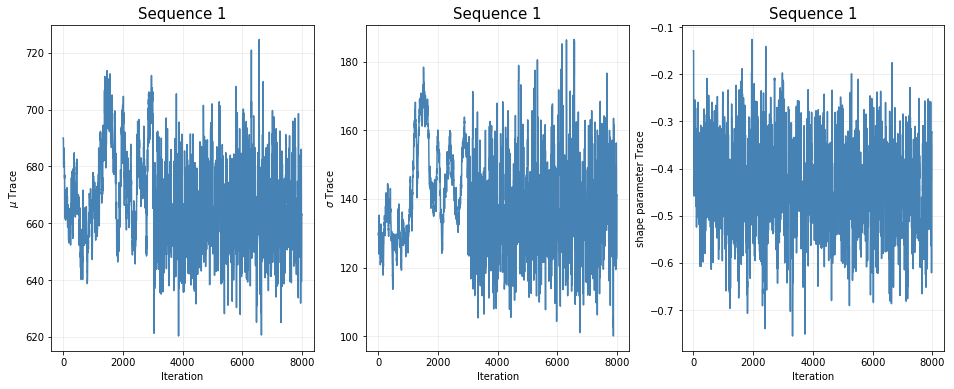

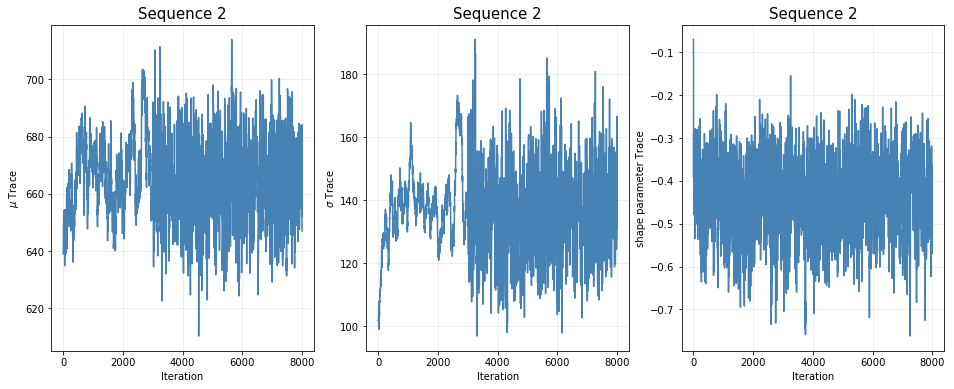

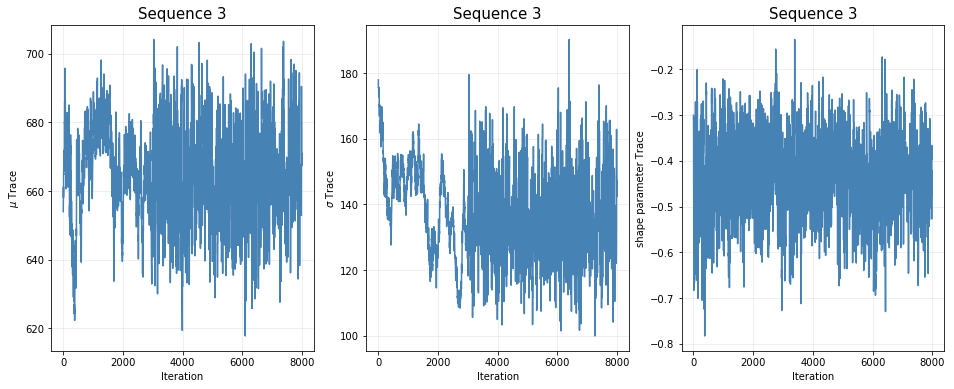

In [17]:
plot_sequences(mcmc_chains)

## GR diagnostic:

In [18]:
def GR_diag(parameter, interval=100, start=100, plot=True):
    end = len(parameter[0])
    m = len(parameter)
    GR_result = []
    x_range = []
    for n in range(start, end, interval):
        x_range.append(n)
        sequences = []
        for i in range(m):
            sequences.append(parameter[i][:n])
        GR_result.append(psrf(sequences))
    if plot:
        plt.figure(figsize=(14, 6))
        plt.scatter(x=x_range, y=GR_result)
        plt.xlabel('iteration', fontsize=14)
        plt.ylabel('potential scale reduction fator', fontsize=14)
        plt.title('Gelman & Rubin Diagnostic', fontsize=14)
        plt.show()
    return GR_result

def psrf(sequences):
    u = [np.mean(sequence) for sequence in sequences]
    s = [np.var(sequence, ddof=1) for sequence in sequences]
    m = len(sequences)
    n = len(sequences[0])
    U = np.mean(u)
    B, W = 0, 0
    for i in range(m):
        B += (u[i] - U)**2
        W += s[i]
    B = (B*n)/(m-1)
    W = W/m
    Var = (1-(1/n))*W + (B/n)
    return np.sqrt(Var/W)

In [19]:
u_raw, s_raw, shape_raw =[], [], []

for mcmc_chain in mcmc_chains:
    u_raw.append(mcmc_chain[0])
    s_raw.append(mcmc_chain[1])
    shape_raw.append(mcmc_chain[2])

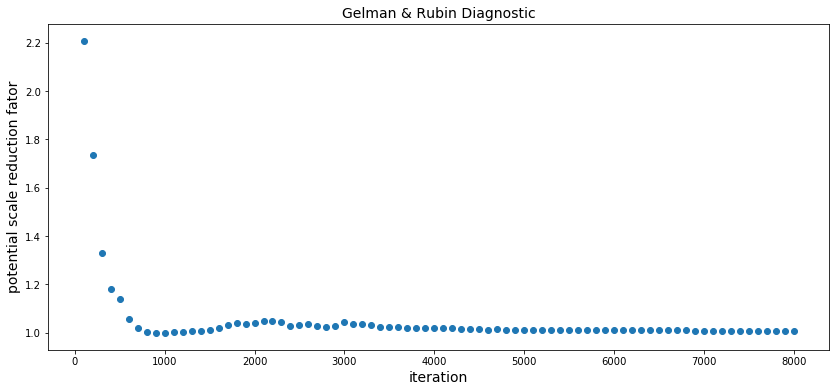

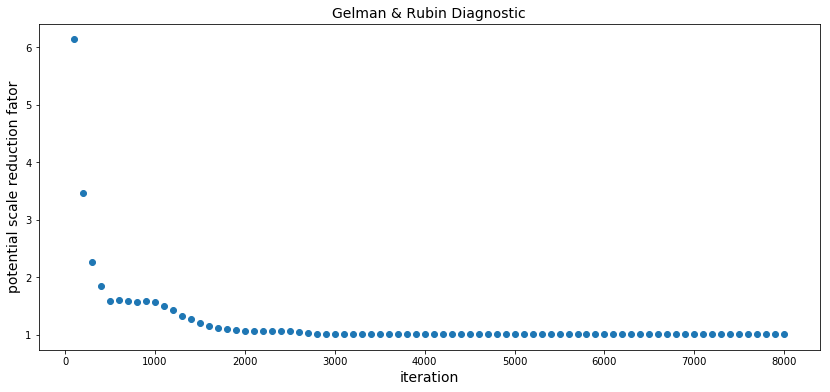

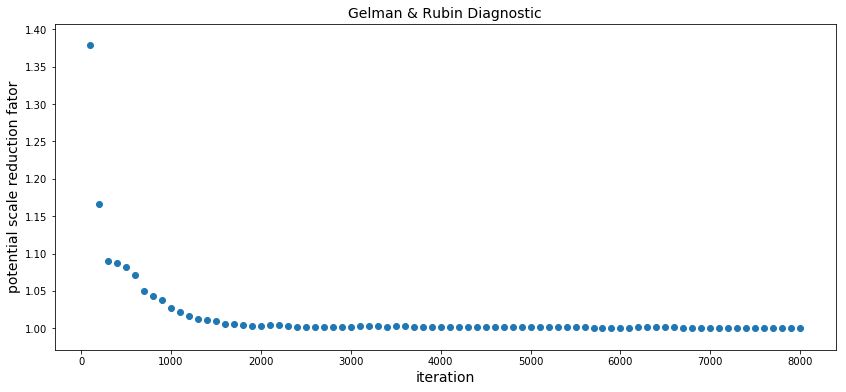

In [20]:
GR_u = GR_diag(u_raw)
GR_s = GR_diag(s_raw)
GR_shape = GR_diag(shape_raw)

## Distribution Fitting:

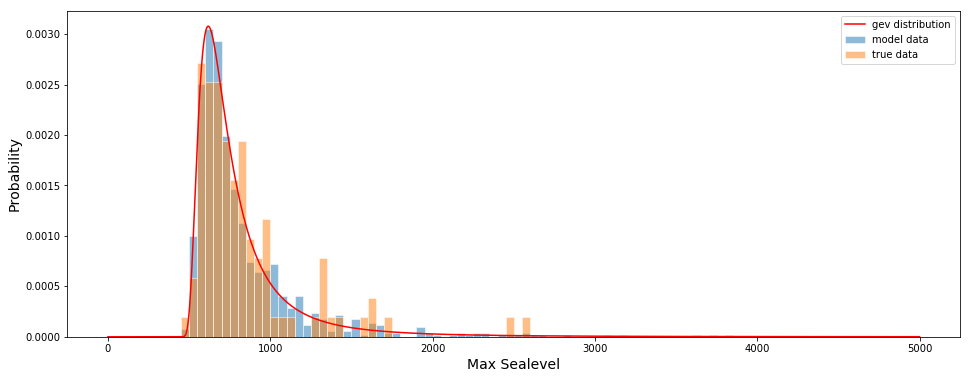

661.927405899 130.1534231 -0.441699919115 -735.223865791


In [29]:
max_indices = []
maxs = []
for i in range(len(mcmc_chains)):
    max_indices.append(np.where(np.array(ls[i]) == np.array(ls[i]).max())[0][0])
    maxs.append(np.array(ls[i]).max())
index = np.where(np.array(maxs) == np.array(maxs).max())[0][0]
i = max_indices[index]


x_range = np.arange(0, 5000, 1)
y_range = [stats.genextreme.pdf(x=xi, c=shape_raw[index][i], loc=u_raw[index][i], scale=s_raw[index][i]) for xi in x_range]

samples = stats.genextreme.rvs(c=shape_raw[index][i], loc=u_raw[index][i], scale=s_raw[index][i], size=1000)

plt.figure(figsize=(16,6))
plt.hist(samples, bins=np.arange(0, 5000, 50), normed=True, edgecolor='white', alpha=0.5, label='model data')
plt.hist(data_meas, bins=np.arange(0, 5000, 50), normed=True, edgecolor='white', alpha=0.5, label='true data')
plt.plot(x_range, y_range, label='gev distribution', color='r')
plt.legend()
plt.xlabel('Max Sealevel', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.show()
print (u_raw[index][i], s_raw[index][i], shape_raw[index][i], ls[index][i])

## Auto Correlation Function:

In [375]:
def ACF(X, end=200, interval=1, plot=True):
    N = len(X)
    acf = []
    x_range = []
    for a in range(0, end, interval):
        x_range.append(a)
        acf.append(np.corrcoef(X[a:], X[:N-a])[0][1])
    if plot:
        plt.figure(figsize=(8, 6))
        plt.stem(x_range, acf)
        plt.xlabel('Lag', fontsize=12)
        plt.ylabel('ACF', fontsize=12)
        plt.show()
    return acf

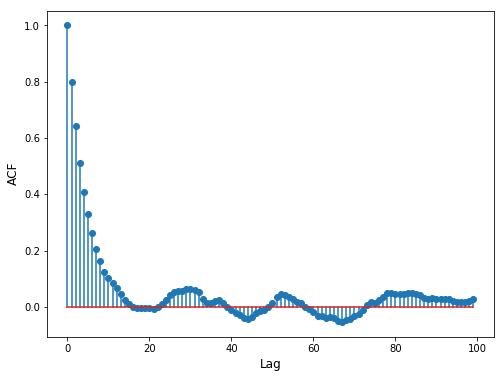

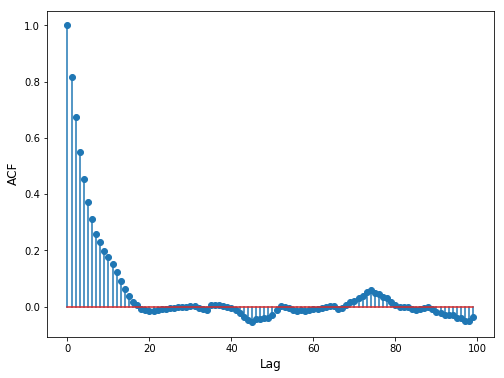

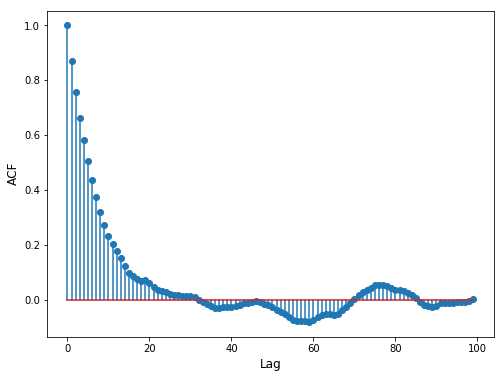

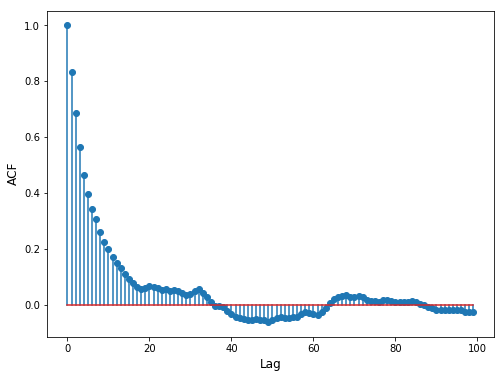

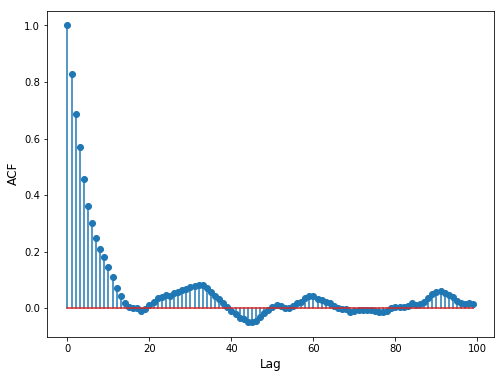

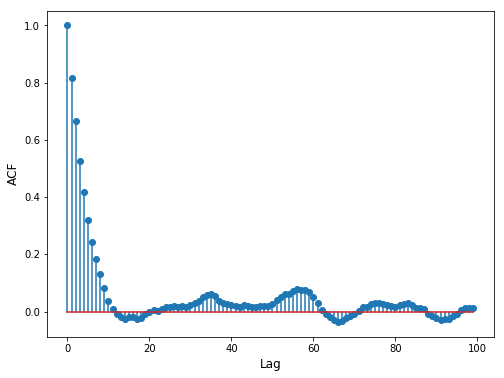

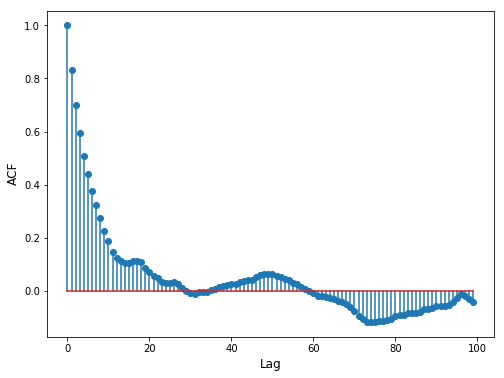

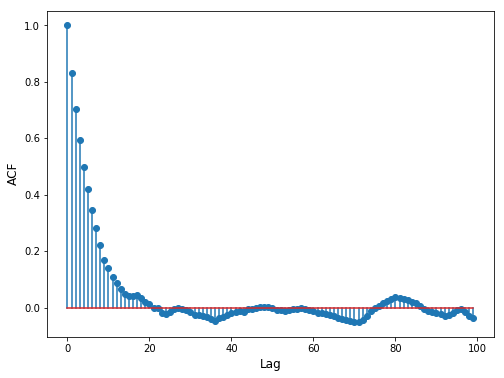

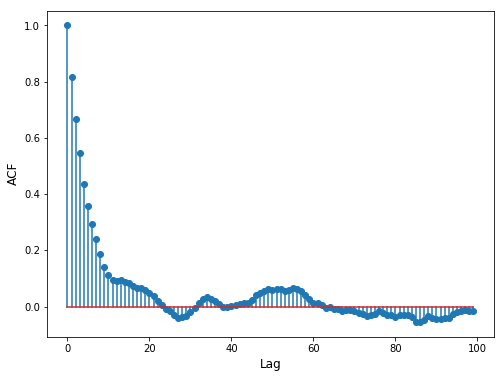

In [388]:
acf_u = []
acf_s = []
acf_shape = []
for i in range(len(u_raw)):
    acf_u.append(ACF(u_raw[i][burnin:], end=100))
    acf_s.append(ACF(s_raw[i][burnin:], end=100))
    acf_shape.append(ACF(shape_raw[i][burnin:], end=100))

## Helper Functions:

In [14]:
def sequences_generator(m, data_meas, logpost, t, stepsize, n_iter):
    problems = []
    for i in range(m):
        ui = np.random.randint(low=600, high=800)
        si = np.random.randint(low=100, high=200)
        shapei = np.random.choice(a=np.arange(0, -0.4, -0.01))
        theta =[ui, si, shapei]
        state = State(theta, logpost(theta, data_meas))
        problems.append(ProblemMCMC(state, logpost, stepsize, data_meas, t))
    ar, mcmc_chains, ls = [], [], []
    for i in range(m):
        u, s, shape, l, r = mcmc(problems[i], n_iter)
        mcmc_chains.append([u, s, shape])
        ar.append(r)
        ls.append(l)
    return mcmc_chains, ar, ls

In [15]:
def plot_sequences(mcmc_chains):
    for i in range(len(mcmc_chains)):
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
        ax[0].plot(mcmc_chains[i][0], color="steelblue");
        ax[0].set_xlabel("Iteration");
        ax[0].set_ylabel("$\mu$ Trace");
        ax[0].set_title("Sequence {}".format(i+1), fontsize=15);
        ax[0].grid(alpha=0.25);
        ax[1].plot(mcmc_chains[i][1], color="steelblue");
        ax[1].set_xlabel("Iteration");
        ax[1].set_ylabel("$\sigma$ Trace");
        ax[1].set_title("Sequence {}".format(i+1), fontsize=15);
        ax[1].grid(alpha=0.25);
        ax[2].plot(mcmc_chains[i][2], color="steelblue");
        ax[2].set_xlabel("Iteration");
        ax[2].set_ylabel("shape parameter Trace");
        ax[2].set_title("Sequence {}".format(i+1), fontsize=15);
        ax[2].grid(alpha=0.25);